<a href="https://colab.research.google.com/github/EldarsUP/semantic_methods/blob/main/Homework5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas scikit-learn nltk pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 21.2 MB/s eta 0:00:00


In [2]:
import nltk
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer
import math

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')


class Processing:
    def tokenize(self, text: str) -> list[str]:
        return word_tokenize(text)

    def lematize(self, tokens: list[str]) -> list[str]:
        morph3 = MorphAnalyzer()
        lemmatized_words = [morph3.parse(
            word)[0].normal_form for word in tokens]
        return lemmatized_words

    def stemming(self, tokens: list[str]) -> list[str]:
        stemmer = SnowballStemmer("english")
        lemmatized_words = [stemmer.stem(word) for word in tokens]
        return lemmatized_words

    def vectorize(self, tokens: list[str]) -> list[int]:
        dict_vectors = {}
        result = []
        for word in tokens:
            if word in dict_vectors.keys():
                result.append(dict_vectors[word])
            else:
                dict_vectors[word] = len(dict_vectors)
                result.append(dict_vectors[word])
        return result

    def vectorize_dict(self, tokens: list[str]) -> list[int]:
        dict_vectors = {}
        for word in tokens:
            if word not in dict_vectors.keys():
                dict_vectors[word] = len(dict_vectors)
        return dict_vectors

    def delete_stop_words(self, tokens: list[str]) -> list[int]:
        stop_words = set(stopwords.words('english')).union(
            ['.', ',', ':', '?', '!', '(', ')'])
        return [word for word in tokens if word not in stop_words]

    def bag_of_words(self, tokens: list[str]) -> dict[str]:
        dict_words = {}
        for word in tokens:
            dict_words[word] = dict_words.setdefault(word, 0) + 1
        return dict_words

    def tf(self, tokens: list[str]) -> dict[str]:
        dict_words = self.bag_of_words(tokens)
        for word in dict_words:
            dict_words[word] /= len(tokens)
        return dict_words

    def idf(self, texts: list[list[str]]) -> dict[str]:
        dict_words = {}
        big_text = []
        for text in texts:
            big_text += list(set(text))
        for word in set(big_text):
            dict_words[word] = math.log(len(texts) / big_text.count(word))
        return dict_words

    def tf_idf(self, texts: list[list[str]], indexText: int) -> dict[str]:
        tf = self.tf(texts[indexText])
        idf = self.idf(texts)
        dict_words = {}
        for word in tf:
            dict_words[word] = tf[word] * idf[word]
        return dict_words

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Использую датасет https://huggingface.co/datasets/knowledgator/Scientific-text-classification, мне понравился

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('train.csv')
df = df.head(10000)
pc = Processing()

y = df['label']
x = df.copy().drop('label', axis=1)

In [6]:
df

,text,label
0,We will consider the indefinite truncated mu...,mathematics
1,We discuss the Higgs mass and cosmological c...,high energy physics phenomenology
2,While a lot of work in theoretical computer ...,computer science
3,We explore the physics of the gyro-resonant ...,astrophysics
4,Estimating the size of hard-to-reach populat...,statistics
...,...,...
9995,How to contain the spread of the COVID-19 vi...,computer science
9996,HAWC has developed new energy algorithms usi...,astrophysics
9997,We investigate the combined effects of bound...,high energy physics theory
9998,"We analyze a cavity optomechanical setup, in...",quantum physics


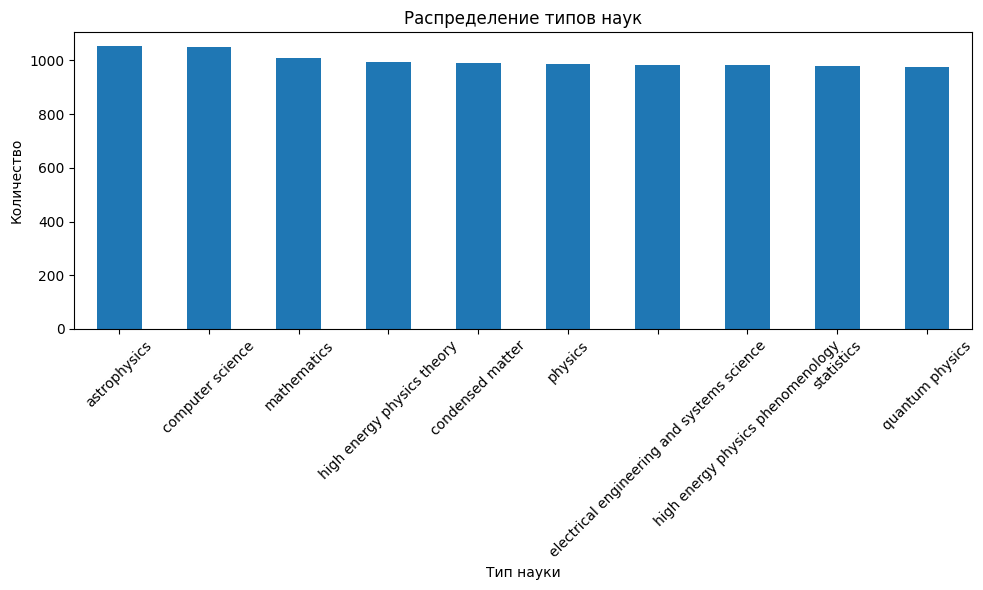

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar')
plt.title('Распределение типов наук')
plt.xlabel('Тип науки')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
for index, row in df.iterrows():
    text = row['text']
    tokens = pc.tokenize(text)  # Токенизация
    tokens = pc.delete_stop_words(tokens)  # Удаление стоп слов

    row['text'] = ' '.join(tokens)



Векторизация через TFIDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text'])

Кластеризация с помощью Spectral Clustering

In [10]:
from sklearn.preprocessing import StandardScaler

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.toarray())

In [11]:
from sklearn.cluster import SpectralClustering

In [12]:
spectral = SpectralClustering(
    n_clusters=4,
    affinity='nearest_neighbors',
    n_neighbors=10,
    random_state=42
)
labels = spectral.fit_predict(X_scaled)

Визуализация

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

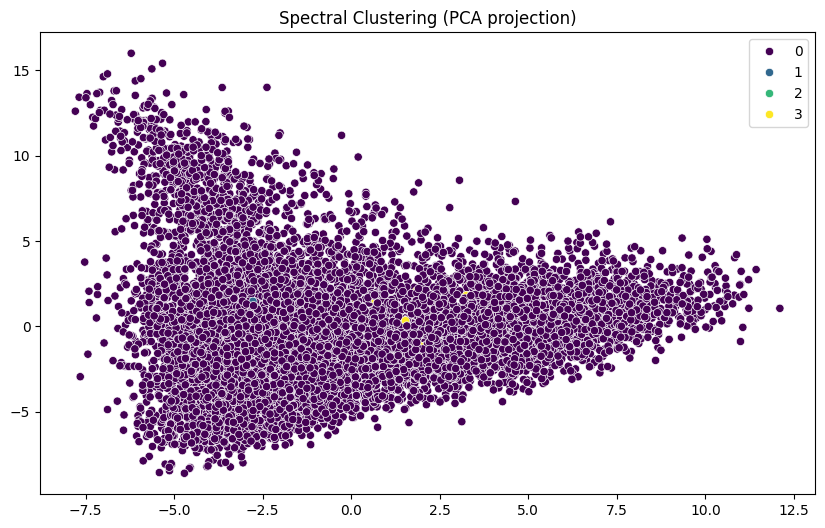

In [14]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=labels,
    palette='viridis',
    legend='full'
)
plt.title('Spectral Clustering (PCA projection)')
plt.show()

In [15]:
from sklearn.metrics import silhouette_score

if len(set(labels)) > 1:
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {score:.3f}")
else:
    print("Все точки в одном кластере!")

# Анализ результатов
df['cluster'] = labels
for cluster in sorted(df['cluster'].unique()):
    print(f"\n Кластер {cluster}:")
    print(df[df['cluster'] == cluster]['label'].value_counts().head(5))

Silhouette Score: -0.052

 Кластер 0:
label
astrophysics                  1052
computer science              1050
mathematics                   1008
high energy physics theory     995
condensed matter               989
Name: count, dtype: int64

 Кластер 1:
label
high energy physics phenomenology             2
quantum physics                               2
physics                                       2
electrical engineering and systems science    1
Name: count, dtype: int64

 Кластер 2:
label
high energy physics phenomenology    9
Name: count, dtype: int64

 Кластер 3:
label
quantum physics                               12
electrical engineering and systems science     2
Name: count, dtype: int64


In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)